In [1]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude"])

In [2]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 64
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.18),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [ ]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=1e-2,
    weight_decay=3e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999, 
    patience=100, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 237618, Validation Loss: 244199, 4.901643965448241
Epoch 101, Training Loss: 63822, Validation Loss: 75390, 115505.72718832786
Epoch 201, Training Loss: 64750, Validation Loss: 58377, 157773.09242055262
Epoch 301, Training Loss: 57438, Validation Loss: 57192, 131955.31950421073
Epoch 401, Training Loss: 62794, Validation Loss: 82477, 105893.43425960625
Epoch 501, Training Loss: 59906, Validation Loss: 67746, 154712.5234409844
Epoch 601, Training Loss: 56398, Validation Loss: 62106, 143045.96713120272
Epoch 701, Training Loss: 60372, Validation Loss: 168912, 102599.8403103687
Epoch 801, Training Loss: 55904, Validation Loss: 57389, 169477.24510295154
Epoch 901, Training Loss: 60868, Validation Loss: 58633, 148765.74806910063
Epoch 00924: reducing learning rate of group 0 to 9.9900e-03.
Epoch 1001, Training Loss: 57928, Validation Loss: 53580, 148000.65755869882
Epoch 01025: reducing learning rate of group 0 to 9.9800e-03.
Epoch 1101, Training Loss: 61289, Validat

Epoch 6501, Training Loss: 49778, Validation Loss: 55482, 90929.4095855466
Epoch 06502: reducing learning rate of group 0 to 9.4741e-03.
Epoch 6601, Training Loss: 51690, Validation Loss: 53204, 95933.37841312143
Epoch 06603: reducing learning rate of group 0 to 9.4646e-03.
Epoch 6701, Training Loss: 52297, Validation Loss: 66845, 137095.54305543765
Epoch 06704: reducing learning rate of group 0 to 9.4551e-03.
Epoch 6801, Training Loss: 50851, Validation Loss: 54155, 138843.5112023227
Epoch 06805: reducing learning rate of group 0 to 9.4457e-03.
Epoch 6901, Training Loss: 51059, Validation Loss: 52701, 131093.14645773373
Epoch 06960: reducing learning rate of group 0 to 9.4362e-03.
Epoch 7001, Training Loss: 47896, Validation Loss: 58193, 105503.8994500561
Epoch 07061: reducing learning rate of group 0 to 9.4268e-03.
Epoch 7101, Training Loss: 49386, Validation Loss: 54902, 147763.48371033216
Epoch 07162: reducing learning rate of group 0 to 9.4174e-03.
Epoch 7201, Training Loss: 50735

Epoch 12645: reducing learning rate of group 0 to 8.9578e-03.
Epoch 12701, Training Loss: 49561, Validation Loss: 51860, 107873.8696744588
Epoch 12800: reducing learning rate of group 0 to 8.9489e-03.
Epoch 12801, Training Loss: 51763, Validation Loss: 54715, 95622.51468398089
Epoch 12901, Training Loss: 49329, Validation Loss: 60460, 94477.72792014561
Epoch 12959: reducing learning rate of group 0 to 8.9399e-03.
Epoch 13001, Training Loss: 46545, Validation Loss: 53403, 87409.93206160713
Epoch 13060: reducing learning rate of group 0 to 8.9310e-03.
Epoch 13101, Training Loss: 46151, Validation Loss: 59621, 84539.31168394558
Epoch 13161: reducing learning rate of group 0 to 8.9221e-03.
Epoch 13201, Training Loss: 45114, Validation Loss: 51706, 59563.38587538896
Epoch 13262: reducing learning rate of group 0 to 8.9131e-03.
Epoch 13301, Training Loss: 47152, Validation Loss: 50866, 91134.80842914048
Epoch 13363: reducing learning rate of group 0 to 8.9042e-03.
Epoch 13401, Training Loss:

Epoch 18701, Training Loss: 43037, Validation Loss: 56599, 82536.27153606045
Epoch 18711: reducing learning rate of group 0 to 8.4528e-03.
Epoch 18801, Training Loss: 43298, Validation Loss: 57732, 93173.59518425603
Epoch 18812: reducing learning rate of group 0 to 8.4444e-03.
Epoch 18901, Training Loss: 43567, Validation Loss: 56540, 65743.9606122034
Epoch 18913: reducing learning rate of group 0 to 8.4359e-03.
Epoch 19001, Training Loss: 42777, Validation Loss: 54452, 69766.40851174305
Epoch 19014: reducing learning rate of group 0 to 8.4275e-03.
Epoch 19101, Training Loss: 42403, Validation Loss: 52360, 88661.60953604062
Epoch 19115: reducing learning rate of group 0 to 8.4191e-03.
Epoch 19201, Training Loss: 45860, Validation Loss: 58323, 58193.174449187565
Epoch 19216: reducing learning rate of group 0 to 8.4106e-03.
Epoch 19301, Training Loss: 44380, Validation Loss: 52751, 63036.33019523054
Epoch 19317: reducing learning rate of group 0 to 8.4022e-03.
Epoch 19401, Training Loss:

Epoch 24667: reducing learning rate of group 0 to 7.9763e-03.
Epoch 24701, Training Loss: 42095, Validation Loss: 54462, 72643.01521585522
Epoch 24768: reducing learning rate of group 0 to 7.9683e-03.
Epoch 24801, Training Loss: 44389, Validation Loss: 59984, 73319.50819990812
Epoch 24869: reducing learning rate of group 0 to 7.9603e-03.
Epoch 24901, Training Loss: 40050, Validation Loss: 54720, 66237.0583959132
Epoch 24970: reducing learning rate of group 0 to 7.9524e-03.
Epoch 25001, Training Loss: 41730, Validation Loss: 51555, 70620.66590926622
Epoch 25071: reducing learning rate of group 0 to 7.9444e-03.
Epoch 25101, Training Loss: 39993, Validation Loss: 55228, 74187.04472094741
Epoch 25172: reducing learning rate of group 0 to 7.9365e-03.
Epoch 25201, Training Loss: 42541, Validation Loss: 61211, 67553.9474084752
Epoch 25273: reducing learning rate of group 0 to 7.9285e-03.
Epoch 25301, Training Loss: 45147, Validation Loss: 52303, 57622.86752188695
Epoch 25401, Training Loss: 4

Epoch 30601, Training Loss: 39042, Validation Loss: 65140, 73236.39172894268
Epoch 30676: reducing learning rate of group 0 to 7.5191e-03.
Epoch 30701, Training Loss: 41697, Validation Loss: 51063, 86333.23300106144
Epoch 30777: reducing learning rate of group 0 to 7.5116e-03.
Epoch 30801, Training Loss: 37160, Validation Loss: 51637, 59966.47711114135
Epoch 30878: reducing learning rate of group 0 to 7.5040e-03.
Epoch 30901, Training Loss: 40922, Validation Loss: 51374, 70687.27364701634
Epoch 30979: reducing learning rate of group 0 to 7.4965e-03.
Epoch 31001, Training Loss: 40216, Validation Loss: 55245, 62349.091923537024
Epoch 31080: reducing learning rate of group 0 to 7.4890e-03.
Epoch 31101, Training Loss: 38418, Validation Loss: 58201, 81251.23506829778
Epoch 31181: reducing learning rate of group 0 to 7.4816e-03.
Epoch 31201, Training Loss: 40000, Validation Loss: 53841, 61092.8271808126
Epoch 31282: reducing learning rate of group 0 to 7.4741e-03.
Epoch 31301, Training Loss:

Epoch 36534: reducing learning rate of group 0 to 7.0952e-03.
Epoch 36601, Training Loss: 39814, Validation Loss: 58436, 82646.72197131149
Epoch 36635: reducing learning rate of group 0 to 7.0881e-03.
Epoch 36701, Training Loss: 40433, Validation Loss: 61890, 84065.3035492763
Epoch 36736: reducing learning rate of group 0 to 7.0810e-03.
Epoch 36801, Training Loss: 40118, Validation Loss: 50713, 80866.47974222731
Epoch 36837: reducing learning rate of group 0 to 7.0739e-03.
Epoch 36901, Training Loss: 37942, Validation Loss: 52836, 61680.32161599363
Epoch 36938: reducing learning rate of group 0 to 7.0668e-03.
Epoch 37001, Training Loss: 38985, Validation Loss: 56812, 67104.0615869971
Epoch 37039: reducing learning rate of group 0 to 7.0598e-03.
Epoch 37101, Training Loss: 37074, Validation Loss: 55729, 60953.57776337161
Epoch 37140: reducing learning rate of group 0 to 7.0527e-03.
Epoch 37201, Training Loss: 38412, Validation Loss: 54188, 71383.34783272764
Epoch 37241: reducing learnin

Epoch 42594: reducing learning rate of group 0 to 6.6818e-03.
Epoch 42601, Training Loss: 35414, Validation Loss: 50587, 76091.27768300241
Epoch 42695: reducing learning rate of group 0 to 6.6751e-03.
Epoch 42701, Training Loss: 38269, Validation Loss: 50163, 72042.7185639383
Epoch 42796: reducing learning rate of group 0 to 6.6684e-03.
Epoch 42801, Training Loss: 36223, Validation Loss: 52424, 74080.99363306521
Epoch 42897: reducing learning rate of group 0 to 6.6617e-03.
Epoch 42901, Training Loss: 38257, Validation Loss: 51656, 89714.51073796715
Epoch 42998: reducing learning rate of group 0 to 6.6551e-03.
Epoch 43001, Training Loss: 36980, Validation Loss: 52442, 66140.8326538039
Epoch 43099: reducing learning rate of group 0 to 6.6484e-03.
Epoch 43101, Training Loss: 37870, Validation Loss: 53507, 71994.97660054134
Epoch 43200: reducing learning rate of group 0 to 6.6418e-03.
Epoch 43201, Training Loss: 39995, Validation Loss: 56003, 62457.4255507549
Epoch 43301: reducing learning

Epoch 48501, Training Loss: 36320, Validation Loss: 53556, 60781.77746595943
Epoch 48553: reducing learning rate of group 0 to 6.2988e-03.
Epoch 48601, Training Loss: 36385, Validation Loss: 56897, 71505.5519354909
Epoch 48654: reducing learning rate of group 0 to 6.2925e-03.
Epoch 48701, Training Loss: 34111, Validation Loss: 56649, 78165.74063992522
Epoch 48755: reducing learning rate of group 0 to 6.2862e-03.
Epoch 48801, Training Loss: 36361, Validation Loss: 58149, 78598.40296818729
Epoch 48856: reducing learning rate of group 0 to 6.2799e-03.
Epoch 48901, Training Loss: 35084, Validation Loss: 53951, 68716.69253269274
Epoch 48957: reducing learning rate of group 0 to 6.2736e-03.
Epoch 49001, Training Loss: 34930, Validation Loss: 52394, 56861.90241490663
Epoch 49058: reducing learning rate of group 0 to 6.2673e-03.
Epoch 49101, Training Loss: 36333, Validation Loss: 55313, 74525.15040172475
Epoch 49159: reducing learning rate of group 0 to 6.2611e-03.
Epoch 49201, Training Loss: 

Epoch 54501, Training Loss: 36577, Validation Loss: 54163, 68000.56173291408
Epoch 54512: reducing learning rate of group 0 to 5.9377e-03.
Epoch 54601, Training Loss: 37434, Validation Loss: 54179, 82709.58601982292
Epoch 54613: reducing learning rate of group 0 to 5.9318e-03.
Epoch 54701, Training Loss: 35943, Validation Loss: 53115, 66093.28196591813
Epoch 54714: reducing learning rate of group 0 to 5.9258e-03.
Epoch 54801, Training Loss: 35070, Validation Loss: 56117, 68814.53079623311
Epoch 54815: reducing learning rate of group 0 to 5.9199e-03.
Epoch 54901, Training Loss: 32036, Validation Loss: 54373, 70707.00149234787
Epoch 54916: reducing learning rate of group 0 to 5.9140e-03.
Epoch 55001, Training Loss: 35421, Validation Loss: 54090, 60464.071614690714
Epoch 55017: reducing learning rate of group 0 to 5.9081e-03.
Epoch 55101, Training Loss: 39047, Validation Loss: 50646, 73934.88590211056
Epoch 55118: reducing learning rate of group 0 to 5.9022e-03.
Epoch 55201, Training Loss

Epoch 60401, Training Loss: 32582, Validation Loss: 52283, 65606.95380549692
Epoch 60471: reducing learning rate of group 0 to 5.5974e-03.
Epoch 60501, Training Loss: 36000, Validation Loss: 55183, 56153.93620651838
Epoch 60572: reducing learning rate of group 0 to 5.5918e-03.
Epoch 60601, Training Loss: 34436, Validation Loss: 51338, 100323.60037983886
Epoch 60673: reducing learning rate of group 0 to 5.5862e-03.
Epoch 60701, Training Loss: 33965, Validation Loss: 53091, 72419.0418107506
Epoch 60774: reducing learning rate of group 0 to 5.5806e-03.
Epoch 60801, Training Loss: 35945, Validation Loss: 53906, 70480.73381636072
Epoch 60875: reducing learning rate of group 0 to 5.5750e-03.
Epoch 60901, Training Loss: 33668, Validation Loss: 54205, 79410.99757098219
Epoch 60976: reducing learning rate of group 0 to 5.5694e-03.
Epoch 61001, Training Loss: 36610, Validation Loss: 56163, 74861.92337913146
Epoch 61077: reducing learning rate of group 0 to 5.5639e-03.
Epoch 61101, Training Loss:

Epoch 66329: reducing learning rate of group 0 to 5.2818e-03.
Epoch 66401, Training Loss: 31668, Validation Loss: 54936, 78949.8565020673
Epoch 66430: reducing learning rate of group 0 to 5.2765e-03.
Epoch 66501, Training Loss: 34466, Validation Loss: 52820, 76522.15154150118
Epoch 66531: reducing learning rate of group 0 to 5.2712e-03.
Epoch 66601, Training Loss: 36701, Validation Loss: 54916, 75032.70204232018
Epoch 66632: reducing learning rate of group 0 to 5.2660e-03.
Epoch 66701, Training Loss: 33351, Validation Loss: 51115, 83083.98718077813
Epoch 66733: reducing learning rate of group 0 to 5.2607e-03.
Epoch 66801, Training Loss: 32664, Validation Loss: 53624, 76436.77344530523
Epoch 66834: reducing learning rate of group 0 to 5.2554e-03.
Epoch 66901, Training Loss: 33514, Validation Loss: 53700, 78878.56174495337
Epoch 66935: reducing learning rate of group 0 to 5.2502e-03.
Epoch 67001, Training Loss: 29917, Validation Loss: 51708, 78028.5143738089
Epoch 67036: reducing learnin

Epoch 72288: reducing learning rate of group 0 to 4.9790e-03.
Epoch 72301, Training Loss: 32448, Validation Loss: 55842, 75382.77898045773
Epoch 72389: reducing learning rate of group 0 to 4.9741e-03.
Epoch 72401, Training Loss: 33942, Validation Loss: 52129, 66898.65018481125
Epoch 72490: reducing learning rate of group 0 to 4.9691e-03.
Epoch 72501, Training Loss: 34744, Validation Loss: 52194, 75177.41861740455
Epoch 72591: reducing learning rate of group 0 to 4.9641e-03.
Epoch 72601, Training Loss: 31973, Validation Loss: 50463, 83695.58660877064
Epoch 72692: reducing learning rate of group 0 to 4.9592e-03.
Epoch 72701, Training Loss: 32895, Validation Loss: 55723, 77823.8829116401
Epoch 72793: reducing learning rate of group 0 to 4.9542e-03.
Epoch 72801, Training Loss: 33120, Validation Loss: 52337, 67726.1779463428
Epoch 72894: reducing learning rate of group 0 to 4.9492e-03.
Epoch 72901, Training Loss: 31776, Validation Loss: 57323, 79219.2091614129
Epoch 72995: reducing learning

Epoch 78247: reducing learning rate of group 0 to 4.6936e-03.
Epoch 78301, Training Loss: 30385, Validation Loss: 52237, 81320.00256680645
Epoch 78348: reducing learning rate of group 0 to 4.6889e-03.
Epoch 78401, Training Loss: 34503, Validation Loss: 56260, 76812.9307981403
Epoch 78449: reducing learning rate of group 0 to 4.6843e-03.
Epoch 78501, Training Loss: 31492, Validation Loss: 56294, 67805.5325616305
Epoch 78550: reducing learning rate of group 0 to 4.6796e-03.
Epoch 78601, Training Loss: 31734, Validation Loss: 53082, 70947.7373047715
Epoch 78651: reducing learning rate of group 0 to 4.6749e-03.
Epoch 78701, Training Loss: 33421, Validation Loss: 52044, 64567.18730769379
Epoch 78752: reducing learning rate of group 0 to 4.6702e-03.
Epoch 78801, Training Loss: 34230, Validation Loss: 54224, 70217.79566391675
Epoch 78853: reducing learning rate of group 0 to 4.6655e-03.
Epoch 78901, Training Loss: 32793, Validation Loss: 55096, 74290.91229650246
Epoch 78954: reducing learning

Epoch 84201, Training Loss: 31646, Validation Loss: 55290, 79688.77330217404
Epoch 84206: reducing learning rate of group 0 to 4.4246e-03.
Epoch 84301, Training Loss: 36511, Validation Loss: 53233, 83123.62976062471
Epoch 84307: reducing learning rate of group 0 to 4.4202e-03.
Epoch 84401, Training Loss: 30621, Validation Loss: 57943, 77086.5754634336
Epoch 84408: reducing learning rate of group 0 to 4.4157e-03.
Epoch 84501, Training Loss: 35115, Validation Loss: 54136, 71193.72023889176
Epoch 84509: reducing learning rate of group 0 to 4.4113e-03.
Epoch 84601, Training Loss: 33510, Validation Loss: 54412, 70849.09368067935
Epoch 84610: reducing learning rate of group 0 to 4.4069e-03.
Epoch 84701, Training Loss: 29225, Validation Loss: 54518, 76862.31476852445
Epoch 84711: reducing learning rate of group 0 to 4.4025e-03.
Epoch 84801, Training Loss: 32178, Validation Loss: 52645, 66509.75339753012
Epoch 84812: reducing learning rate of group 0 to 4.3981e-03.
Epoch 84901, Training Loss: 

Epoch 90165: reducing learning rate of group 0 to 4.1710e-03.
Epoch 90201, Training Loss: 29192, Validation Loss: 55548, 72225.35283814033
Epoch 90266: reducing learning rate of group 0 to 4.1668e-03.
Epoch 90301, Training Loss: 32469, Validation Loss: 58224, 87257.18426713771
Epoch 90367: reducing learning rate of group 0 to 4.1626e-03.
Epoch 90401, Training Loss: 31483, Validation Loss: 57924, 76619.16752972633
Epoch 90468: reducing learning rate of group 0 to 4.1585e-03.
Epoch 90501, Training Loss: 30011, Validation Loss: 53242, 77899.07648855665
Epoch 90569: reducing learning rate of group 0 to 4.1543e-03.
Epoch 90601, Training Loss: 31080, Validation Loss: 54115, 67472.00305439625
Epoch 90670: reducing learning rate of group 0 to 4.1502e-03.
Epoch 90701, Training Loss: 29803, Validation Loss: 56609, 78983.90092481201
Epoch 90771: reducing learning rate of group 0 to 4.1460e-03.
Epoch 90801, Training Loss: 29354, Validation Loss: 57518, 70849.97986905226
Epoch 90872: reducing learn

Epoch 96124: reducing learning rate of group 0 to 3.9319e-03.
Epoch 96201, Training Loss: 30962, Validation Loss: 53141, 78188.36754663913
Epoch 96225: reducing learning rate of group 0 to 3.9280e-03.
Epoch 96301, Training Loss: 30051, Validation Loss: 53238, 81005.94994572276
Epoch 96326: reducing learning rate of group 0 to 3.9240e-03.
Epoch 96401, Training Loss: 29603, Validation Loss: 53258, 73715.10637944234
Epoch 96427: reducing learning rate of group 0 to 3.9201e-03.
Epoch 96501, Training Loss: 32166, Validation Loss: 53593, 87249.30125825519
Epoch 96528: reducing learning rate of group 0 to 3.9162e-03.
Epoch 96601, Training Loss: 31997, Validation Loss: 55755, 93779.48656487298
Epoch 96629: reducing learning rate of group 0 to 3.9123e-03.
Epoch 96701, Training Loss: 30782, Validation Loss: 56520, 74535.55672502374
Epoch 96730: reducing learning rate of group 0 to 3.9083e-03.
Epoch 96801, Training Loss: 30928, Validation Loss: 51610, 83503.7377977036
Epoch 96831: reducing learni

Epoch 102083: reducing learning rate of group 0 to 3.7065e-03.
Epoch 102101, Training Loss: 29554, Validation Loss: 55734, 77777.84880839473
Epoch 102184: reducing learning rate of group 0 to 3.7028e-03.
Epoch 102201, Training Loss: 30164, Validation Loss: 53193, 69685.55659145978
Epoch 102285: reducing learning rate of group 0 to 3.6991e-03.
Epoch 102301, Training Loss: 31618, Validation Loss: 53789, 99015.89473739993
Epoch 102386: reducing learning rate of group 0 to 3.6954e-03.
Epoch 102401, Training Loss: 28598, Validation Loss: 53466, 76457.02216260976
Epoch 102487: reducing learning rate of group 0 to 3.6917e-03.
Epoch 102501, Training Loss: 27836, Validation Loss: 53624, 74765.94972702696
Epoch 102588: reducing learning rate of group 0 to 3.6880e-03.
Epoch 102601, Training Loss: 31593, Validation Loss: 54437, 85068.5733787671
Epoch 102689: reducing learning rate of group 0 to 3.6843e-03.
Epoch 102701, Training Loss: 34165, Validation Loss: 58057, 101110.66075281102
Epoch 102790:

Epoch 107941: reducing learning rate of group 0 to 3.4975e-03.
Epoch 108001, Training Loss: 31256, Validation Loss: 52811, 65733.25268857641
Epoch 108042: reducing learning rate of group 0 to 3.4940e-03.
Epoch 108101, Training Loss: 30384, Validation Loss: 57071, 81814.04256072284
Epoch 108143: reducing learning rate of group 0 to 3.4905e-03.
Epoch 108201, Training Loss: 30977, Validation Loss: 55068, 91202.0637826867
Epoch 108244: reducing learning rate of group 0 to 3.4871e-03.
Epoch 108301, Training Loss: 30354, Validation Loss: 55198, 83076.99765686771
Epoch 108345: reducing learning rate of group 0 to 3.4836e-03.
Epoch 108401, Training Loss: 29830, Validation Loss: 54386, 96540.15596838172
Epoch 108446: reducing learning rate of group 0 to 3.4801e-03.
Epoch 108501, Training Loss: 29542, Validation Loss: 56422, 90990.40106756415
Epoch 108547: reducing learning rate of group 0 to 3.4766e-03.
Epoch 108601, Training Loss: 33272, Validation Loss: 54383, 76484.16680898365
Epoch 108648: 

Epoch 113900: reducing learning rate of group 0 to 3.2971e-03.
Epoch 113901, Training Loss: 28916, Validation Loss: 55183, 82474.17165479601
Epoch 114001: reducing learning rate of group 0 to 3.2938e-03.
Epoch 114001, Training Loss: 30777, Validation Loss: 54530, 84387.71064960536
Epoch 114101, Training Loss: 30232, Validation Loss: 53169, 81364.26407724193
Epoch 114102: reducing learning rate of group 0 to 3.2905e-03.
Epoch 114201, Training Loss: 31601, Validation Loss: 53635, 76904.84887786371
Epoch 114203: reducing learning rate of group 0 to 3.2872e-03.
Epoch 114301, Training Loss: 28785, Validation Loss: 53427, 82640.78540513005
Epoch 114304: reducing learning rate of group 0 to 3.2839e-03.
Epoch 114401, Training Loss: 28380, Validation Loss: 55090, 85556.75259117364
Epoch 114405: reducing learning rate of group 0 to 3.2806e-03.
Epoch 114501, Training Loss: 29650, Validation Loss: 53722, 82661.24273434361
Epoch 114506: reducing learning rate of group 0 to 3.2773e-03.
Epoch 114601,

Epoch 119758: reducing learning rate of group 0 to 3.1112e-03.
Epoch 119801, Training Loss: 31221, Validation Loss: 111974, 94815.61064406372
Epoch 119859: reducing learning rate of group 0 to 3.1081e-03.
Epoch 119901, Training Loss: 28904, Validation Loss: 125316, 79645.89482151976
Epoch 119960: reducing learning rate of group 0 to 3.1050e-03.
Epoch 120001, Training Loss: 28849, Validation Loss: 53771, 89432.20958943221
Epoch 120061: reducing learning rate of group 0 to 3.1019e-03.
Epoch 120101, Training Loss: 28694, Validation Loss: 53049, 83648.49483346328
Epoch 120162: reducing learning rate of group 0 to 3.0988e-03.
Epoch 120201, Training Loss: 28047, Validation Loss: 57388, 83173.47984100856
Epoch 120263: reducing learning rate of group 0 to 3.0957e-03.
Epoch 120301, Training Loss: 30308, Validation Loss: 54892, 85513.9370088795
Epoch 120364: reducing learning rate of group 0 to 3.0926e-03.
Epoch 120401, Training Loss: 29864, Validation Loss: 56292, 78571.81656870608
Epoch 120465

Epoch 125701, Training Loss: 29854, Validation Loss: 55403, 100662.60885859503
Epoch 125717: reducing learning rate of group 0 to 2.9328e-03.
Epoch 125801, Training Loss: 26433, Validation Loss: 52919, 78743.41670371236
Epoch 125818: reducing learning rate of group 0 to 2.9299e-03.
Epoch 125901, Training Loss: 29751, Validation Loss: 53080, 88888.92965979148
Epoch 125919: reducing learning rate of group 0 to 2.9270e-03.
Epoch 126001, Training Loss: 28829, Validation Loss: 54129, 71745.90379815653
Epoch 126020: reducing learning rate of group 0 to 2.9241e-03.
Epoch 126101, Training Loss: 32756, Validation Loss: 54732, 92624.62727598035
Epoch 126121: reducing learning rate of group 0 to 2.9211e-03.
Epoch 126201, Training Loss: 29128, Validation Loss: 55030, 87393.78553364771
Epoch 126222: reducing learning rate of group 0 to 2.9182e-03.
Epoch 126301, Training Loss: 28657, Validation Loss: 57386, 103472.1777533181
Epoch 126323: reducing learning rate of group 0 to 2.9153e-03.
Epoch 126401

Epoch 131575: reducing learning rate of group 0 to 2.7675e-03.
Epoch 131601, Training Loss: 31463, Validation Loss: 56372, 82991.71691506558
Epoch 131676: reducing learning rate of group 0 to 2.7647e-03.
Epoch 131701, Training Loss: 28638, Validation Loss: 56077, 77237.96608629373
Epoch 131777: reducing learning rate of group 0 to 2.7620e-03.
Epoch 131801, Training Loss: 32173, Validation Loss: 58951, 95393.9114833229
Epoch 131878: reducing learning rate of group 0 to 2.7592e-03.
Epoch 131901, Training Loss: 33403, Validation Loss: 55626, 95558.60549732768
Epoch 131979: reducing learning rate of group 0 to 2.7564e-03.
Epoch 132001, Training Loss: 27865, Validation Loss: 55567, 2621975.7277731425
Epoch 132080: reducing learning rate of group 0 to 2.7537e-03.
Epoch 132101, Training Loss: 28279, Validation Loss: 52357, 64165.81326956752
Epoch 132181: reducing learning rate of group 0 to 2.7509e-03.
Epoch 132201, Training Loss: 28219, Validation Loss: 56993, 85432.20883220543
Epoch 132282:

Epoch 137433: reducing learning rate of group 0 to 2.6115e-03.
Epoch 137501, Training Loss: 27840, Validation Loss: 85139, 82957.2067248427
Epoch 137534: reducing learning rate of group 0 to 2.6089e-03.
Epoch 137601, Training Loss: 28934, Validation Loss: 84687, 84368.03011334575
Epoch 137635: reducing learning rate of group 0 to 2.6063e-03.
Epoch 137701, Training Loss: 28994, Validation Loss: 88157, 90907.78266898806
Epoch 137736: reducing learning rate of group 0 to 2.6036e-03.
Epoch 137801, Training Loss: 29134, Validation Loss: 90792, 70950.19770310547
Epoch 137837: reducing learning rate of group 0 to 2.6010e-03.
Epoch 137901, Training Loss: 30974, Validation Loss: 89082, 100000.72772055653
Epoch 137938: reducing learning rate of group 0 to 2.5984e-03.
Epoch 138001, Training Loss: 28576, Validation Loss: 91467, 92688.21025582065
Epoch 138039: reducing learning rate of group 0 to 2.5958e-03.
Epoch 138101, Training Loss: 28877, Validation Loss: 89094, 77331.92852648627
Epoch 138140:

Epoch 143392: reducing learning rate of group 0 to 2.4618e-03.
Epoch 143401, Training Loss: 32492, Validation Loss: 56373, 79098.14577925987
Epoch 143493: reducing learning rate of group 0 to 2.4593e-03.
Epoch 143501, Training Loss: 30264, Validation Loss: 56744, 83983.6884380908
Epoch 143594: reducing learning rate of group 0 to 2.4569e-03.
Epoch 143601, Training Loss: 28647, Validation Loss: 54871, 91995.16832768127
Epoch 143695: reducing learning rate of group 0 to 2.4544e-03.
Epoch 143701, Training Loss: 29332, Validation Loss: 55231, 81815.50463088803
Epoch 143796: reducing learning rate of group 0 to 2.4519e-03.
Epoch 143801, Training Loss: 31225, Validation Loss: 57107, 74435.93612978321
Epoch 143897: reducing learning rate of group 0 to 2.4495e-03.
Epoch 143901, Training Loss: 28093, Validation Loss: 58043, 80680.39143868403
Epoch 143998: reducing learning rate of group 0 to 2.4470e-03.
Epoch 144001, Training Loss: 28025, Validation Loss: 54124, 118650.8289861426
Epoch 144099: 

Epoch 149250: reducing learning rate of group 0 to 2.3230e-03.
Epoch 149301, Training Loss: 28954, Validation Loss: 55542, 78497.060991479
Epoch 149351: reducing learning rate of group 0 to 2.3207e-03.
Epoch 149401, Training Loss: 27526, Validation Loss: 55196, 77501.14219468541
Epoch 149452: reducing learning rate of group 0 to 2.3183e-03.
Epoch 149501, Training Loss: 27616, Validation Loss: 55169, 72396.76879649387
Epoch 149553: reducing learning rate of group 0 to 2.3160e-03.
Epoch 149601, Training Loss: 27388, Validation Loss: 54645, 85212.62574185517
Epoch 149654: reducing learning rate of group 0 to 2.3137e-03.
Epoch 149701, Training Loss: 29217, Validation Loss: 57500, 70489.2510163071
Epoch 149755: reducing learning rate of group 0 to 2.3114e-03.
Epoch 149801, Training Loss: 28945, Validation Loss: 53550, 83848.62406497473
Epoch 149856: reducing learning rate of group 0 to 2.3091e-03.
Epoch 149901, Training Loss: 29158, Validation Loss: 56000, 91838.50292651712
Epoch 149957: re

Epoch 155201, Training Loss: 27634, Validation Loss: 56173, 81300.07723061663
Epoch 155209: reducing learning rate of group 0 to 2.1898e-03.
Epoch 155301, Training Loss: 28855, Validation Loss: 56241, 84241.90534427334
Epoch 155310: reducing learning rate of group 0 to 2.1876e-03.
Epoch 155401, Training Loss: 27961, Validation Loss: 54899, 89433.44712604203
Epoch 155411: reducing learning rate of group 0 to 2.1855e-03.
Epoch 155501, Training Loss: 28596, Validation Loss: 53799, 72015.50396300408
Epoch 155512: reducing learning rate of group 0 to 2.1833e-03.
Epoch 155601, Training Loss: 28262, Validation Loss: 55990, 83509.90625616357
Epoch 155613: reducing learning rate of group 0 to 2.1811e-03.
Epoch 155701, Training Loss: 28684, Validation Loss: 54137, 93454.27643345977
Epoch 155714: reducing learning rate of group 0 to 2.1789e-03.
Epoch 155801, Training Loss: 26866, Validation Loss: 53885, 73267.93599552097
Epoch 155815: reducing learning rate of group 0 to 2.1767e-03.
Epoch 155901,

Epoch 161067: reducing learning rate of group 0 to 2.0664e-03.
Epoch 161101, Training Loss: 28618, Validation Loss: 54778, 89742.93608873589
Epoch 161168: reducing learning rate of group 0 to 2.0643e-03.
Epoch 161201, Training Loss: 28348, Validation Loss: 53490, 81600.51210590889
Epoch 161269: reducing learning rate of group 0 to 2.0622e-03.
Epoch 161301, Training Loss: 27898, Validation Loss: 55242, 86609.98105054814
Epoch 161370: reducing learning rate of group 0 to 2.0602e-03.
Epoch 161401, Training Loss: 29057, Validation Loss: 54365, 78764.4353709584
Epoch 161471: reducing learning rate of group 0 to 2.0581e-03.
Epoch 161501, Training Loss: 29235, Validation Loss: 55610, 103627.34358062537
Epoch 161572: reducing learning rate of group 0 to 2.0561e-03.
Epoch 161601, Training Loss: 28417, Validation Loss: 55187, 71021.22549874494
Epoch 161673: reducing learning rate of group 0 to 2.0540e-03.
Epoch 161701, Training Loss: 29796, Validation Loss: 54096, 82639.90169566472
Epoch 161774:

Epoch 166925: reducing learning rate of group 0 to 1.9499e-03.
Epoch 167001, Training Loss: 27692, Validation Loss: 56176, 105023.01635243504
Epoch 167026: reducing learning rate of group 0 to 1.9479e-03.
Epoch 167101, Training Loss: 27734, Validation Loss: 55750, 98820.65487524215
Epoch 167127: reducing learning rate of group 0 to 1.9460e-03.
Epoch 167201, Training Loss: 27575, Validation Loss: 52924, 83482.68113199237
Epoch 167228: reducing learning rate of group 0 to 1.9440e-03.
Epoch 167301, Training Loss: 28185, Validation Loss: 56181, 81198.3748158553
Epoch 167329: reducing learning rate of group 0 to 1.9421e-03.
Epoch 167401, Training Loss: 27433, Validation Loss: 55151, 82842.36248263935
Epoch 167430: reducing learning rate of group 0 to 1.9401e-03.
Epoch 167501, Training Loss: 28732, Validation Loss: 53630, 89610.67876415445
Epoch 167531: reducing learning rate of group 0 to 1.9382e-03.
Epoch 167601, Training Loss: 30208, Validation Loss: 53915, 104260.19471847377
Epoch 167632

Epoch 172884: reducing learning rate of group 0 to 1.8381e-03.
Epoch 172901, Training Loss: 27459, Validation Loss: 55432, 112207.20081511175
Epoch 172985: reducing learning rate of group 0 to 1.8363e-03.
Epoch 173001, Training Loss: 25662, Validation Loss: 57587, 88741.31568987941
Epoch 173086: reducing learning rate of group 0 to 1.8344e-03.
Epoch 173101, Training Loss: 28103, Validation Loss: 57761, 83811.34234915965
Epoch 173187: reducing learning rate of group 0 to 1.8326e-03.
Epoch 173201, Training Loss: 26789, Validation Loss: 54815, 92955.42916805879
Epoch 173288: reducing learning rate of group 0 to 1.8308e-03.
Epoch 173301, Training Loss: 29851, Validation Loss: 56006, 81571.55088451804
Epoch 173389: reducing learning rate of group 0 to 1.8289e-03.
Epoch 173401, Training Loss: 29356, Validation Loss: 55611, 98876.48084266581
Epoch 173490: reducing learning rate of group 0 to 1.8271e-03.
Epoch 173501, Training Loss: 27415, Validation Loss: 56005, 84016.65537479882
Epoch 173591

Epoch 178742: reducing learning rate of group 0 to 1.7345e-03.
Epoch 178801, Training Loss: 29429, Validation Loss: 55656, 89047.41479060224
Epoch 178843: reducing learning rate of group 0 to 1.7327e-03.
Epoch 178901, Training Loss: 27905, Validation Loss: 54696, 89238.25091289787
Epoch 178944: reducing learning rate of group 0 to 1.7310e-03.
Epoch 179001, Training Loss: 27767, Validation Loss: 55518, 108661.24560193093
Epoch 179045: reducing learning rate of group 0 to 1.7293e-03.
Epoch 179101, Training Loss: 26653, Validation Loss: 53637, 80652.70451981915
Epoch 179146: reducing learning rate of group 0 to 1.7276e-03.
Epoch 179201, Training Loss: 27318, Validation Loss: 55719, 97469.4807372754
Epoch 179247: reducing learning rate of group 0 to 1.7258e-03.
Epoch 179301, Training Loss: 31504, Validation Loss: 54930, 88615.4236590501
Epoch 179348: reducing learning rate of group 0 to 1.7241e-03.
Epoch 179401, Training Loss: 26599, Validation Loss: 55081, 82275.11805154358
Epoch 179449: 

Epoch 184701: reducing learning rate of group 0 to 1.6351e-03.
Epoch 184701, Training Loss: 27763, Validation Loss: 55253, 95685.89573885726
Epoch 184801, Training Loss: 29234, Validation Loss: 57303, 92628.49454694008
Epoch 184802: reducing learning rate of group 0 to 1.6334e-03.
Epoch 184901, Training Loss: 29688, Validation Loss: 55861, 91374.79851001171
Epoch 184903: reducing learning rate of group 0 to 1.6318e-03.
Epoch 185001, Training Loss: 26824, Validation Loss: 54494, 84779.94756480114
Epoch 185004: reducing learning rate of group 0 to 1.6302e-03.
Epoch 185101, Training Loss: 30897, Validation Loss: 56247, 101626.92556945991
Epoch 185105: reducing learning rate of group 0 to 1.6285e-03.
Epoch 185201, Training Loss: 26270, Validation Loss: 53934, 89435.81929617951
Epoch 185206: reducing learning rate of group 0 to 1.6269e-03.
Epoch 185301, Training Loss: 27650, Validation Loss: 53911, 100305.56820334122
Epoch 185307: reducing learning rate of group 0 to 1.6253e-03.
Epoch 18540

Epoch 190559: reducing learning rate of group 0 to 1.5429e-03.
Epoch 190601, Training Loss: 26070, Validation Loss: 56566, 102756.77555736166
Epoch 190660: reducing learning rate of group 0 to 1.5413e-03.
Epoch 190701, Training Loss: 29697, Validation Loss: 56893, 101799.98641316935
Epoch 190761: reducing learning rate of group 0 to 1.5398e-03.
Epoch 190801, Training Loss: 27449, Validation Loss: 56198, 88311.7112614473
Epoch 190862: reducing learning rate of group 0 to 1.5383e-03.
Epoch 190901, Training Loss: 27893, Validation Loss: 55404, 83740.89827573077
Epoch 190963: reducing learning rate of group 0 to 1.5367e-03.
Epoch 191001, Training Loss: 28097, Validation Loss: 54808, 96424.30604303667
Epoch 191064: reducing learning rate of group 0 to 1.5352e-03.
Epoch 191101, Training Loss: 28733, Validation Loss: 54736, 91131.98751651047
Epoch 191165: reducing learning rate of group 0 to 1.5336e-03.
Epoch 191201, Training Loss: 28291, Validation Loss: 55743, 92111.60757047993
Epoch 191266

Epoch 196401, Training Loss: 26447, Validation Loss: 54636, 83251.28877815166
Epoch 196417: reducing learning rate of group 0 to 1.4559e-03.
Epoch 196501, Training Loss: 28033, Validation Loss: 55153, 87851.96167142077
Epoch 196518: reducing learning rate of group 0 to 1.4544e-03.
Epoch 196601, Training Loss: 25622, Validation Loss: 55647, 96118.58560090464
Epoch 196619: reducing learning rate of group 0 to 1.4530e-03.
Epoch 196701, Training Loss: 27586, Validation Loss: 53927, 100210.62205763487
Epoch 196720: reducing learning rate of group 0 to 1.4515e-03.
Epoch 196801, Training Loss: 27745, Validation Loss: 57246, 87159.05061996124
Epoch 196821: reducing learning rate of group 0 to 1.4501e-03.
Epoch 196901, Training Loss: 28587, Validation Loss: 55241, 106733.68710090325
Epoch 196922: reducing learning rate of group 0 to 1.4486e-03.
Epoch 197001, Training Loss: 25671, Validation Loss: 55071, 81088.15687925612
Epoch 197023: reducing learning rate of group 0 to 1.4472e-03.
Epoch 19710

Epoch 202275: reducing learning rate of group 0 to 1.3738e-03.
Epoch 202301, Training Loss: 26568, Validation Loss: 55581, 100917.1373294932
Epoch 202376: reducing learning rate of group 0 to 1.3724e-03.
Epoch 202401, Training Loss: 26126, Validation Loss: 56321, 112097.73840642931
Epoch 202477: reducing learning rate of group 0 to 1.3711e-03.
Epoch 202501, Training Loss: 28627, Validation Loss: 54822, 92515.58056352237
Epoch 202578: reducing learning rate of group 0 to 1.3697e-03.
Epoch 202601, Training Loss: 26978, Validation Loss: 55175, 90329.68178519794
Epoch 202679: reducing learning rate of group 0 to 1.3683e-03.
Epoch 202701, Training Loss: 30688, Validation Loss: 56774, 83850.93032704142
Epoch 202780: reducing learning rate of group 0 to 1.3670e-03.
Epoch 202801, Training Loss: 25556, Validation Loss: 54069, 79794.51640018848
Epoch 202881: reducing learning rate of group 0 to 1.3656e-03.
Epoch 202901, Training Loss: 27266, Validation Loss: 55701, 124010.82454318453
Epoch 20298

Epoch 208133: reducing learning rate of group 0 to 1.2964e-03.
Epoch 208201, Training Loss: 29057, Validation Loss: 55034, 113760.76437112004
Epoch 208234: reducing learning rate of group 0 to 1.2951e-03.
Epoch 208301, Training Loss: 26874, Validation Loss: 55122, 106802.37552853541
Epoch 208335: reducing learning rate of group 0 to 1.2938e-03.
Epoch 208401, Training Loss: 27372, Validation Loss: 54879, 88469.29328426854
Epoch 208436: reducing learning rate of group 0 to 1.2925e-03.
Epoch 208501, Training Loss: 26379, Validation Loss: 54823, 99178.72778620078
Epoch 208537: reducing learning rate of group 0 to 1.2912e-03.
Epoch 208601, Training Loss: 26258, Validation Loss: 54803, 86209.05222159276
Epoch 208638: reducing learning rate of group 0 to 1.2899e-03.
Epoch 208701, Training Loss: 29123, Validation Loss: 55821, 82044.35870519903
Epoch 208739: reducing learning rate of group 0 to 1.2886e-03.
Epoch 208801, Training Loss: 26926, Validation Loss: 55387, 92669.26354462151
Epoch 20884

Epoch 214092: reducing learning rate of group 0 to 1.2221e-03.
Epoch 214101, Training Loss: 26988, Validation Loss: 55481, 101821.89352640758
Epoch 214193: reducing learning rate of group 0 to 1.2208e-03.
Epoch 214201, Training Loss: 24025, Validation Loss: 54620, 112288.80855987211
Epoch 214294: reducing learning rate of group 0 to 1.2196e-03.
Epoch 214301, Training Loss: 28807, Validation Loss: 54997, 96554.84846650493
Epoch 214395: reducing learning rate of group 0 to 1.2184e-03.
Epoch 214401, Training Loss: 28058, Validation Loss: 54687, 112953.31506429698
Epoch 214496: reducing learning rate of group 0 to 1.2172e-03.
Epoch 214501, Training Loss: 25971, Validation Loss: 55558, 103046.76576138659
Epoch 214597: reducing learning rate of group 0 to 1.2160e-03.
Epoch 214601, Training Loss: 27289, Validation Loss: 56605, 88457.93164637852
Epoch 214698: reducing learning rate of group 0 to 1.2147e-03.
Epoch 214701, Training Loss: 26332, Validation Loss: 54585, 104275.19044096256
Epoch 21

Epoch 219901, Training Loss: 26804, Validation Loss: 55090, 105783.41173265106
Epoch 219950: reducing learning rate of group 0 to 1.1532e-03.
Epoch 220001, Training Loss: 27774, Validation Loss: 55673, 109749.64169011521
Epoch 220051: reducing learning rate of group 0 to 1.1520e-03.
Epoch 220101, Training Loss: 32261, Validation Loss: 56007, 104036.43271844789
Epoch 220152: reducing learning rate of group 0 to 1.1509e-03.
Epoch 220201, Training Loss: 28266, Validation Loss: 54163, 99633.12246816584
Epoch 220253: reducing learning rate of group 0 to 1.1497e-03.
Epoch 220301, Training Loss: 26653, Validation Loss: 56234, 83527.26681435578
Epoch 220354: reducing learning rate of group 0 to 1.1486e-03.
Epoch 220401, Training Loss: 27467, Validation Loss: 56703, 102328.3991908045
Epoch 220455: reducing learning rate of group 0 to 1.1474e-03.
Epoch 220501, Training Loss: 27401, Validation Loss: 55730, 94785.491219175
Epoch 220556: reducing learning rate of group 0 to 1.1463e-03.
Epoch 220601

Epoch 225801, Training Loss: 24935, Validation Loss: 55144, 99194.38278326021
Epoch 225808: reducing learning rate of group 0 to 1.0881e-03.
Epoch 225901, Training Loss: 26991, Validation Loss: 55947, 105389.65315803797
Epoch 225909: reducing learning rate of group 0 to 1.0871e-03.
Epoch 226001, Training Loss: 26807, Validation Loss: 54761, 101145.12069085364
Epoch 226010: reducing learning rate of group 0 to 1.0860e-03.
Epoch 226101, Training Loss: 29562, Validation Loss: 55600, 116208.77523744595
Epoch 226111: reducing learning rate of group 0 to 1.0849e-03.
Epoch 226201, Training Loss: 28608, Validation Loss: 55975, 99536.24168364068
Epoch 226212: reducing learning rate of group 0 to 1.0838e-03.
Epoch 226301, Training Loss: 28569, Validation Loss: 55309, 89183.15604309102
Epoch 226313: reducing learning rate of group 0 to 1.0827e-03.
Epoch 226401, Training Loss: 28433, Validation Loss: 55405, 101359.21299077729
Epoch 226414: reducing learning rate of group 0 to 1.0816e-03.
Epoch 226

Epoch 231601, Training Loss: 25207, Validation Loss: 55075, 98074.37989637016
Epoch 231666: reducing learning rate of group 0 to 1.0268e-03.
Epoch 231701, Training Loss: 25247, Validation Loss: 56585, 141676.4816155023
Epoch 231767: reducing learning rate of group 0 to 1.0258e-03.
Epoch 231801, Training Loss: 27977, Validation Loss: 57052, 118297.50934471095
Epoch 231868: reducing learning rate of group 0 to 1.0247e-03.
Epoch 231901, Training Loss: 26839, Validation Loss: 56168, 98207.50203762641
Epoch 231969: reducing learning rate of group 0 to 1.0237e-03.
Epoch 232001, Training Loss: 26927, Validation Loss: 54288, 93522.72742906299
Epoch 232070: reducing learning rate of group 0 to 1.0227e-03.
Epoch 232101, Training Loss: 26061, Validation Loss: 55465, 85620.60496880404
Epoch 232171: reducing learning rate of group 0 to 1.0217e-03.
Epoch 232201, Training Loss: 24754, Validation Loss: 55736, 119587.30061069755
Epoch 232272: reducing learning rate of group 0 to 1.0207e-03.
Epoch 23230

Epoch 237423: reducing learning rate of group 0 to 9.6988e-04.
Epoch 237501, Training Loss: 25659, Validation Loss: 55005, 99606.78165998119
Epoch 237524: reducing learning rate of group 0 to 9.6891e-04.
Epoch 237601, Training Loss: 26495, Validation Loss: 55342, 138708.62334739018
Epoch 237625: reducing learning rate of group 0 to 9.6794e-04.
Epoch 237701, Training Loss: 27539, Validation Loss: 55844, 119643.1816660278
Epoch 237726: reducing learning rate of group 0 to 9.6697e-04.
Epoch 237801, Training Loss: 28792, Validation Loss: 56479, 107382.65827268781
Epoch 237827: reducing learning rate of group 0 to 9.6601e-04.
Epoch 237901, Training Loss: 27787, Validation Loss: 56414, 107867.4244360657
Epoch 237928: reducing learning rate of group 0 to 9.6504e-04.
Epoch 238001, Training Loss: 24216, Validation Loss: 54746, 106136.33558781986
Epoch 238029: reducing learning rate of group 0 to 9.6408e-04.
Epoch 238101, Training Loss: 25495, Validation Loss: 55065, 99553.36094321072
Epoch 2381

Epoch 243281: reducing learning rate of group 0 to 9.1520e-04.
Epoch 243301, Training Loss: 26751, Validation Loss: 55489, 104647.57221318975
Epoch 243382: reducing learning rate of group 0 to 9.1429e-04.
Epoch 243401, Training Loss: 26671, Validation Loss: 55810, 111631.00629270128
Epoch 243483: reducing learning rate of group 0 to 9.1337e-04.
Epoch 243501, Training Loss: 26563, Validation Loss: 56005, 111235.71221299369
Epoch 243584: reducing learning rate of group 0 to 9.1246e-04.
Epoch 243601, Training Loss: 26577, Validation Loss: 54753, 96843.85928522861
Epoch 243685: reducing learning rate of group 0 to 9.1155e-04.
Epoch 243701, Training Loss: 27199, Validation Loss: 55181, 105901.52216575394
Epoch 243786: reducing learning rate of group 0 to 9.1063e-04.
Epoch 243801, Training Loss: 25486, Validation Loss: 55409, 96729.53474408267
Epoch 243887: reducing learning rate of group 0 to 9.0972e-04.
Epoch 243901, Training Loss: 27012, Validation Loss: 56273, 91265.71150497043
Epoch 243

Epoch 249101, Training Loss: 25490, Validation Loss: 55112, 125065.99982402485
Epoch 249139: reducing learning rate of group 0 to 8.6361e-04.
Epoch 249201, Training Loss: 26573, Validation Loss: 55477, 105528.22471112676
Epoch 249240: reducing learning rate of group 0 to 8.6274e-04.
Epoch 249301, Training Loss: 26626, Validation Loss: 55342, 97744.2275453667
Epoch 249341: reducing learning rate of group 0 to 8.6188e-04.
Epoch 249401, Training Loss: 24730, Validation Loss: 55469, 118943.65056965947
Epoch 249442: reducing learning rate of group 0 to 8.6102e-04.
Epoch 249501, Training Loss: 27595, Validation Loss: 55049, 136329.1714361111
Epoch 249543: reducing learning rate of group 0 to 8.6016e-04.
Epoch 249601, Training Loss: 25091, Validation Loss: 55397, 144757.2719729384
Epoch 249644: reducing learning rate of group 0 to 8.5930e-04.
Epoch 249701, Training Loss: 26176, Validation Loss: 56223, 99819.72398978908
Epoch 249745: reducing learning rate of group 0 to 8.5844e-04.
Epoch 24980

Epoch 254997: reducing learning rate of group 0 to 8.1492e-04.
Epoch 255001, Training Loss: 26239, Validation Loss: 55843, 125257.96042273148
Epoch 255098: reducing learning rate of group 0 to 8.1410e-04.
Epoch 255101, Training Loss: 27345, Validation Loss: 55452, 105017.81855020493
Epoch 255199: reducing learning rate of group 0 to 8.1329e-04.
Epoch 255201, Training Loss: 27081, Validation Loss: 55621, 111750.86788522918
Epoch 255300: reducing learning rate of group 0 to 8.1247e-04.
Epoch 255301, Training Loss: 27149, Validation Loss: 56779, 114413.1773595931
Epoch 255401: reducing learning rate of group 0 to 8.1166e-04.
Epoch 255401, Training Loss: 26259, Validation Loss: 55373, 104221.84630939446
Epoch 255501, Training Loss: 27619, Validation Loss: 56113, 120973.54980958482
Epoch 255502: reducing learning rate of group 0 to 8.1085e-04.
Epoch 255601, Training Loss: 24606, Validation Loss: 55665, 101412.51720591821
Epoch 255603: reducing learning rate of group 0 to 8.1004e-04.
Epoch 2

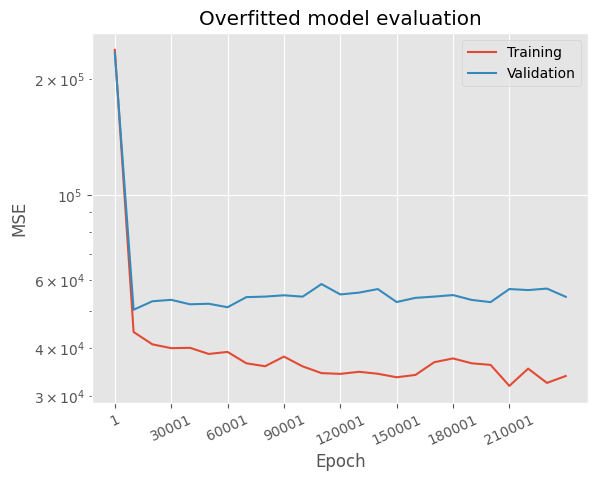

In [6]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.style.use("ggplot")
plt.title("Overfitted model evaluation")


# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)

# Saving. Good results

In [ ]:
# class TabularFFNNSimple(nn.Module):
#     def __init__(self, input_size, output_size, dropout_prob=0.4):
#         super(TabularFFNNSimple, self).__init__()
#         hidden_size = 48
#         self.ffnn = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
# #             nn.BatchNorm1d(hidden_size),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, output_size)
#         )
        
#         for m in self.ffnn:
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0)

#     def forward(self, x):
#         x = x.float()
#         # print(x)
#         x = x.view(x.size(0), -1)
#         x = self.ffnn(x)
#         return x
    
# # Split the data into features and target
# X = data.drop('price', axis=1)
# y = data['price']

# # Standardize the features
# device = torch.device("cpu")
# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
# y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# # Split the data into training and combined validation and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
#                                                             test_size=0.4, random_state=42)

# # Split the combined validation and testing sets
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Create DataLoader for training, validation, and testing
# train_data = TensorDataset(X_train, y_train)
# val_data = TensorDataset(X_val, y_val)
# test_data = TensorDataset(X_test, y_test)

# batch_size = 256
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Check if the dimensions match the expected input size for the model
# input_size = X_train.shape[1]

# # Output
# # input_size, train_loader, test_loader

# model = TabularFFNNSimple(
#     input_size = input_size,
#     output_size = 1
# )
# model.to(device)

# num_epochs = 300000
# train_losses = []
# val_losses = []
# epochs_suc = [] # to have a reference to it
# grad_norms = []

# def get_gradient_norm(model):
#     total_norm = 0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2)
#             total_norm += param_norm.item() ** 2
#     total_norm = total_norm ** 0.5
#     return total_norm

# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=9e-3,
#     weight_decay=1e-4
# )
# criterion = torch.nn.MSELoss()
# criterion_abs = torch.nn.L1Loss()
# criterion = criterion_abs

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.999999, 
#     patience=10, 
#     verbose=True
# )

# for epoch in range(num_epochs):
#     # Training
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     l1_losses = []
#     grad_norm = 0
#     for tuple_ in train_loader:
#         datas, prices = tuple_
#         optimizer.zero_grad()
#         outputs = model(datas)
#         prices_viewed = prices.view(-1, 1).float()
#         loss = criterion(outputs, prices_viewed)
#         loss.backward()
#         grad_norm += get_gradient_norm(model)
#         optimizer.step()

#         running_loss += loss.item()
        
#     grad_norms.append(grad_norm / len(train_loader))
#     train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation
#         for tuple_ in val_loader:
#             datas, prices = tuple_
#             outputs = model(datas)  # Forward pass
#             prices_viewed = prices.view(-1, 1).float()
#             loss = criterion(outputs, prices_viewed)  # Compute loss
#             val_loss += loss.item()  # Accumulate the loss
#             l1_losses.append(criterion_abs(outputs, prices_viewed))

#     val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
#     l1_mean_loss = sum(l1_losses) / len(l1_losses)
#     # Print epoch's summary
#     epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
#     if epoch % 100 == 0:
#         tl = f"Training Loss: {int(train_losses[-1])}"
#         vl = f"Validation Loss: {int(val_losses[-1])}"
#         l1 = f"L1: {int(l1_mean_loss)}"
#         dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
#         print(dl)